# Conexión por SSH

Inicializar la conexion ssh


In [65]:
import paramiko
import getpass

host = "158.251.88.197"
port = 22
username = "gonzalo"
password = getpass.getpass()

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(host, port, username, password)

Para cerrar el servidor MCLP

In [66]:
def close_mclp_server(port=8060):
    stdin, stdout, stderr = ssh.exec_command("echo END | netcat localhost "+str(port))
    print(stdout.readlines()[0])
    

# LoadBoxes(path,instance)
--
Se carga las cajas de una instancia

In [67]:
import numpy as np

dimBox = dict()
vol = dict()

def loadBoxes(idClass, boxSize, idInstance):
    filePath = '../benchs/class'+str(idClass)+'/'+str(boxSize)+'.txt'
    instanceIndex = -1
    countBox = 0
    totalBox = 0
    boxesinfo = []
    binDim = []
    
    boxesFile = open(filePath,'r')
    
    #Lectura del archivo
    for line in boxesFile.readlines():
        info = line.strip().split()
        
        if(instanceIndex < idInstance and len(info) == 4):
            instanceIndex+=1
            totalBox = int(info[0])
        
        elif(instanceIndex == idInstance):
            #La instancia que se esta buscando
            if(len(info) == 4):
                instanceIndex+=1
                totalBox = int(info[0])
                binDim = [int(info[i]) for i in range(1, len(info))]
                binDim = np.array(binDim)
            
            elif(len(info) == 3 and countBox < totalBox):
                countBox+=1    
                b = np.array([int(info[i]) for i in range(0, len(info))])
                b.sort()
                boxesinfo.append(b)

    countBox = 0
    for boxSize in boxesinfo:
        dimBox[countBox] = np.array(boxSize)
        countBox +=1


Implementé un *servidor MCLP*, el cual escucha instrucciones para generar bins.

El siguiente código lanza el servidor en el background, carga una instancia y lo deja escuchando peticiones por el puerto 8080

In [68]:
def loadInstance(idClass=1, boxSize=100, idInstance=0, port=8060):
    transport = ssh.get_transport()
    channel = transport.open_session()
    loadBoxes(idClass, boxSize, idInstance)
    channel.exec_command("killall BASIC_BSG_MCLP; ./mclp/Metasolver/BASIC_BSG_MCLP mclp/Metasolver/problems/mclp/benchs/class"+ \
                         str(idClass)+"/"+str(boxSize)+".txt -i "+str(idInstance)+" --port="+str(port))
    return dimBox, channel

boxes, channel = loadInstance(1,100,0,port)   

# Metodos implementados




## Extras 

In [69]:
import matplotlib.pyplot as plt

def createPlot(InitialVol, finalVol):
    id_bins_first = list( InitialVol.keys() )
    size_initial_bins = list( InitialVol.values() )

    id_bins_final = list( finalVol.keys() )
    size_final_bins = list( finalVol.values() )

    plt.plot(id_bins_first, size_initial_bins, label = 'First Solution')
    plt.plot(id_bins_final, size_final_bins, label = 'Final Solution')

    plt.title('Volumen asociado a cada bin')
    plt.legend()
    plt.show()


In [70]:
def calculateComplex(idBox, dim):
    x,y,z = dim
    expo = 1
    vol = x*y*z
    return ( ( (x/z)*(x/y)*(y/z) )**expo ) * vol

In [71]:
def getMostComplexBox(bin):
    idBox = []
    eval = 0
    
    for b in bin:
        boxShape = boxes[b] #Cargar instancia
        
        currentEval = calculateComplex(b,boxShape)    
        if (idBox is None):
            idBox = b
            eval = currentEval
        else:
            if(currentEval > eval):
                idBox = b
                eval = currentEval
    return idBox, eval

In [72]:
import random as rand

def popRandomBin(bins):
    rPos = int(rand.random()*len(bins))
    theBin = bins.pop(rPos)
    return theBin, bins, rPos

In [73]:
def vol(listBoxes):
    totalVol = 0
    for box in listBoxes:
        x,y,z = boxes[box]
        totalVol += x*y*z
    return totalVol


## Generadores 

**Generación de conjunto inicial de bins con BSG**

La siguiente función genera la lista inicial de bins. Cada línea representa un bin indicando el porcentaje de llenado y los ids de sus cajas.

Es necesario modificarla para que en vez de imprimir el contenido de los bins, retorne una estructura adecuada.

In [74]:
volBin = dict() #Volumen de cada bin

def generate_bins(port=8060):
    #probarlo con distintas instancias
    
    local_command = "echo generate_bins | netcat localhost "+str(port)
    stdin, stdout, stderr = ssh.exec_command(local_command)
    flag = False
    bins = []
    count = 0
    for line in stdout.readlines():
        if "BINS:" in line: 
            flag = True
            continue
        if flag:    
            #Modificar igual que generate_bin
            line = line.strip().split()
            vol = float(line[0]) #Porcentaje de llenado del bin
            newBin = np.array([int(line[x]) for x in range(1,len(line))])
            #calcular el volumen
            bins.append(newBin)
            volBin[count] = vol
            count +=1
    #recordar forma del arreglo        
    return bins

**Construcción de bin priorizando cajas (BSG)**

In [75]:
import paramiko
import getpass
import numpy as np

def generate_bin(boxes, new_box, port=8060):
    global channel
    index = 0
    leftboxes = []
    newBin = []
    boxes = np.insert(boxes, 1, new_box)
    boxes_str = [str(box) for box in boxes]
    pboxes_str = str(new_box)
    percent = 0.0

    local_command = "echo generate_bin " + " ".join(boxes_str) + " -1 " + pboxes_str +  " -2 | netcat localhost "+str(port)
    stdin, stdout, stderr = ssh.exec_command(local_command)
    lines = stdout.readlines()

    while( len(lines) == 0 ):
        
        ___, channel = loadInstance(idClass, boxSize, idInstance, port)
        stdin, stdout, stderr = ssh.exec_command("echo generate_bin " + " ".join(boxes_str) + " -1 " + pboxes_str +  " -2 | netcat localhost "+str(port))
        lines = stdout.readlines()
    
    for line in lines: 
        #ajustar linea para almacenar los conjuntos de cajas
        line = line.strip().split()
        
        if(index == 0):
            #primera linea boxes 
            percent = float(line.pop(0))
            newBin = np.array([int(x) for x in line])            
        else:
            #segunda linea left boxes
            leftboxes = np.array([int(x) for x in line])
        index+=1

    return newBin, leftboxes, percent

# Multiple Container Loading Problem

In [76]:
import copy as cp

def reduceBins(bins, toReduce):

    lastBins = cp.deepcopy(bins)
    breakedBin = toReduce
    iterator = 0

    # Desde una caja intentar introducirla en el resto
    while(len(breakedBin) == 0 or iterator < 10):
        #Se hace pop a un bin dentro del universo de bins
        pivBin, bins, id_piv_bin = popRandomBin(bins)    

        #Se obtiene una caja compleja desde el bin que se desea distribuir
        complexBox, evalComplexBox = getMostComplexBox(breakedBin)
        
        #Metodo de llamada al BSG
        boxes, leftBoxes, percent = generate_bin(pivBin, complexBox, port)
        
        #Se calcula la complejidad de la caja más compleja
        dimComplexBox = dimBox[complexBox]
        
        evalComplexBox = calculateComplex(complexBox, dimComplexBox)
        if( vol(leftBoxes) <= vol([complexBox]) ):
            print("Cambio aceptado")
            #Se inserta el nuevo bin dentro del conjunto de bins
            bins.append(boxes)
            
            #Se elimina (desde el conjunto de cajas a repartir) la caja insertada en el nuevo bin 
            index = np.where(breakedBin == complexBox)
            breakedBin = np.delete(breakedBin, index[0])
            
            #Se agregan las cajas que se cambiaron
            breakedBin = np.concatenate((leftBoxes, breakedBin)) 
            
            #Se sea el volumen del bin por el porcentaje obtenido por generate Bin
            volBin[id_piv_bin] = percent

        else:
            bins.append(pivBin)
        iterator+=1
            
    #Regresar al estado anterior si 
    if(len(breakedBin) > 0):
        lastBins.append(toReduce)
        return lastBins, False
    #Sino
    else: 
        return bins, True
        

In [77]:
initialVol = None

def solve(swapIter, port=8060):
    cantBoxes = len(dimBox)
    totalBoxes = boxes
    
    #Llamada a BSG
    print("Generando conjunto inicial de bins")
    bins = generate_bins(port)
    
    firstSol = len(bins)
    initialVol = volBin
    
    for i in range(swapIter):
        print("ITERACION "+str(i))
        toReduce, bins, id_to_reduce = popRandomBin(bins) 
        bins, change = reduceBins(bins, toReduce)
        

        if(change):
            print("Existe cambio")
            volBin[id_to_reduce] = 0.0

    print("Solución inicial: "+str(firstSol)+" - Solución final: " + str(len(bins)))

    createPlot(initialVol, volBin)
    return bins


Generando conjunto inicial de bins
ITERACION 0
Cambio aceptado
ITERACION 1
ITERACION 2
ITERACION 3
ITERACION 4
ITERACION 5
Cambio aceptado
ITERACION 6
Cambio aceptado
ITERACION 7
Cambio aceptado
Cambio aceptado
ITERACION 8
Cambio aceptado
ITERACION 9
Cambio aceptado
Solución inicial: 24 - Solución final: 24


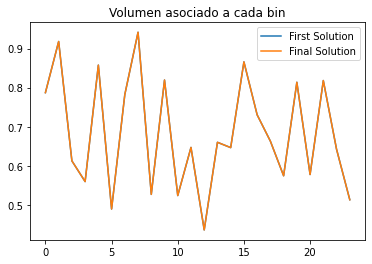

In [78]:
def mclp(idClass, idInstance, boxSize, port=8060):
    swapIter = 10
    bins = solve(swapIter, port)
    return len(bins)

## VARIABLES GLOBALES
global channel
idClass = 1
boxSize = 100
idInstance = 0
port = 8060
boxes, channel = loadInstance(idClass, boxSize, idInstance, port)   

i = mclp(idClass, idInstance, boxSize)

In [79]:
close_mclp_server(port)

Ending MCLP server
